# Imports


In [4]:
!pip install pytorch-ignite

### Libraries

In [5]:
# Model creation
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch import nn, optim
import torch.nn.functional as F
import torch_metrics

# Data manipulation
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print(torch.__version__)
print(torchvision.__version__)

1.7.0+cu101
0.8.1+cu101


### Device

In [6]:
torch.cuda.is_available()

True

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Dataset

In [8]:
root_path = "/content/drive/MyDrive/datas/fruits/"
dataset_path = f"{root_path}clean_dataset/"

In [9]:
h5f = h5py.File(f'{dataset_path}/dataset.h5py', 'r')

np_images = np.array(h5f['images'])
np_labels = np.array(h5f['labels'])

In [10]:
np_images.shape

(3775, 120, 120, 3)

In [11]:
np_labels.shape

(3775,)

In [12]:
np_images = np.swapaxes(np_images, 1, 3)

# Preprocessing

### Split train/test

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(np_images, np_labels, test_size=0.20, random_state=42)

### Custom dataset

In [14]:
transforms_pipe = transforms.Compose([
                                     
  # transforms.RandomSizedCrop(224),
  # transforms.RandomHorizontalFlip(),
  # torchvision.transforms.RandomRotation(10),
  # transforms.ToTensor() 
])

We define two custom Dataset classes

In [15]:
class TrainDataset(torch.utils.data.Dataset):
    """TensorDataset with support of transforms."""

    def __init__(self, arrays, transform=None):

        # Convert to a tuple of tensors
        self.tensors = (torch.Tensor(arrays[0]), torch.LongTensor(arrays[1]))
        self.transform = transform

        # Triggered if the tensors format is incorrect
        assert all(self.tensors[0].size(0) == tensor.size(0) for tensor in self.tensors)

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x.to(device), y.to(device)

    def __len__(self):
        return self.tensors[0].size(0)

In [16]:
class TestDataset(torch.utils.data.Dataset):
    """TensorDataset without transforms."""

    def __init__(self, arrays, transform=None):

        # Convert to a tuple of tensors
        self.tensors = (torch.Tensor(arrays[0]), torch.LongTensor(arrays[1]))

        # Triggered if the tensors format is incorrect
        assert all(self.tensors[0].size(0) == tensor.size(0) for tensor in self.tensors)

    def __getitem__(self, index):
        x = self.tensors[0][index]
        y = self.tensors[1][index]

        return x.to(device), y.to(device)

    def __len__(self):
        return self.tensors[0].size(0)

In [17]:
train_dataset = TrainDataset((X_train, y_train), transforms_pipe)
test_dataset = TestDataset((X_test, y_test), transforms_pipe)

### Dataloader

In [18]:
 BATCH_SIZE = 32

In [19]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Model

### Architecture

In [20]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        # Features detector
        self.features1 = nn.Sequential(
            
            # Hidden layer 1
            nn.Conv2d(3, 16, kernel_size=3), nn.ReLU(),
            nn.BatchNorm2d(16),

            nn.MaxPool2d((2, 2)),
            nn.Dropout(0.35)
        )

        # Features detector
        self.features2 = nn.Sequential(
            
            # Hidden layer 3
            nn.Conv2d(16, 32, kernel_size=3), nn.ReLU(),
            nn.BatchNorm2d(32),

            nn.MaxPool2d((2, 2)),
            nn.Dropout(0.35)
        )

        # Features detector
        self.features3 = nn.Sequential(
            
            # Hidden layer 3
            nn.Conv2d(32, 64, kernel_size=3), nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.MaxPool2d((2, 2)),
            nn.Dropout(0.35)
        )

        # Classifier
        self.classifier = nn.Sequential(
            
            nn.Linear(64*13*13, 512), nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.50),

            # Output layer
            nn.Linear(512, 108)
        )

    def forward(self, X):

        # Features
        X = self.features1(X)
        X = self.features2(X)
        X = self.features3(X)

        # print(X.shape)

        # Classifier
        X = X.view(-1, 64*13*13)
        #X = X.view(X.size(0), -1)
        X = self.classifier(X)

        return F.log_softmax(X, dim=1)

In [21]:
model = CNN()
model.to(device)

# Number of parameters
sum(p.numel() for p in model.parameters() if p.requires_grad)

5618540

### Loss and optimizer

In [22]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.000005)

### Train/test engines

In [23]:
from ignite.engine import Engine

def train_step(engine, batch):

    x, y = batch

    # Pass a batch
    model.train()
    y_pred = model(x)
    loss = criterion(y_pred, y)

    # Learn by backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

def validation_step(engine, batch):
    model.eval()

    with torch.no_grad():
        x, y = batch[0], batch[1]
        y_pred = model(x)

        return y_pred, y

# Define a trainer engine
trainer = Engine(train_step)

# Define an evaluator engine
evaluator = Engine(validation_step)

val_metrics = {
  "accuracy": Accuracy(),
  "loss": Loss(criterion)
}

# Attach metrics to the evaluator
for name, metric in val_metrics.items():
    metric.attach(evaluator, name)

NameError: ignored

### Evaluation metrics

In [ ]:
from ignite.metrics import Accuracy, Loss
from ignite.engine import create_supervised_evaluator
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Events

# Accuracy and loss metrics are defined
val_metrics = {
  "accuracy": Accuracy(),
  "loss": Loss(criterion)
}

train_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)

# Run train_evaluator on train_loader every trainer's epoch completed
@trainer.on(Events.EPOCH_COMPLETED)
def run_train_validation():
    train_evaluator.run(train_loader)

# Run evaluator on val_loader every trainer's epoch completed
@trainer.on(Events.EPOCH_COMPLETED)
def run_validation():
    evaluator.run(test_loader)


@evaluator.on(Events.COMPLETED)
def log_validation_results():
    metrics = evaluator.state.metrics
    print("       Validation - Accuracy: {:.3f} Loss: {:.4f} \n"
          .format(metrics["accuracy"], metrics["loss"]))
    
@train_evaluator.on(Events.COMPLETED)
def log_train_results():
    metrics = train_evaluator.state.metrics
    print("Epoch: {} Training - Accuracy: {:.3f} Loss: {:.4f}"
          .format(trainer.state.epoch, metrics["accuracy"], metrics["loss"]))

ProgressBar().attach(trainer, output_transform=lambda x: {'batch loss': x})

### Training

In [24]:
trainer.run(train_loader, max_epochs=15)

State:
	iteration: 1425
	epoch: 15
	epoch_length: 95
	max_epochs: 15
	output: <class 'torch.Tensor'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: torch.utils.data.dataloader.DataLoader
	seed: <class 'NoneType'>
	times: <class 'dict'>

# Evaluation

In [25]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([], device=device)

    for images, labels in loader:
        preds = model(images)

        all_preds = torch.cat((all_preds, preds),dim=0)
    return all_preds

In [26]:
with torch.no_grad():
    test_preds = get_all_preds(model, test_loader)

In [27]:
from sklearn.metrics import confusion_matrix
prediction = test_preds.argmax(dim=1).to('cpu')

### Confusion matrix

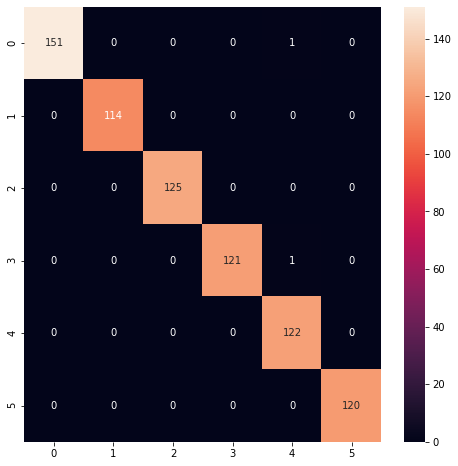

In [29]:
conf_matrix = confusion_matrix(y_test, prediction)

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g')

# Exportation

This model has been trained on GPU

In [31]:
export_path = "./model/"

In [40]:
model.eval()

CNN(
  (features1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.35, inplace=False)
  )
  (features2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.35, inplace=False)
  )
  (features3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.35, inplace=False)
  )
  (classi

### State dict

In [41]:
torch.save(model.state_dict(), export_path + 'state_dict.pt')

### Full model

In [42]:
torch.save(model, export_path + 'full_model.pt')

### Trace script

Create a traced script

In [43]:
sample = torch.rand(1, 3, 120, 120).to(device)
traced_script_module = torch.jit.trace(model, sample)

Test the script

In [44]:
y_pred_sample = traced_script_module(torch.ones(1, 3, 120, 120).to(device))

In [47]:
y_pred_sample.argmax(dim=1)

tensor([1], device='cuda:0')

Save to disk

In [48]:
traced_script_module.save(export_path + "torchscript_model.pt")